In [1]:
# Modify the file 00_setup.py to define input/output file paths on your system
# The information in 00_setup.py will be used across notebooks
from importlib.machinery import SourceFileLoader
setup = SourceFileLoader("setup", "./00_setup.py").load_module()

# 03: Baseline XGBoost Model
Before doing GNN, I will evaluate a more "traditional" model.  Here, I include some selected features, as well as mean-encoded NAICS.  

*This script takes about 5 minutes on my MacBook Air*

In [2]:
import pandas as pd
import numpy as np
import xgboost as xgb
import warnings
import matplotlib.pyplot as plt
import pickle

In [3]:
from pathlib import Path

In [4]:
import sklearn as sk
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, \
    average_precision_score, roc_auc_score
from sklearn.inspection import permutation_importance
from scikitplot.metrics import plot_lift_curve
from sklearn.ensemble import GradientBoostingClassifier

In [5]:
from sba_gnn.sba_gnn import sg_plot 

In [6]:
from PyALE import ale

## Import Processed Datasets

In [ ]:
sba_loans = pd.read_parquet(Path(setup.temp_path).joinpath('01_DATA_transformed.parquet'))

In [ ]:
train_df = sba_loans[sba_loans['dset'] == 'train']
test_df = sba_loans[sba_loans['dset'] == 'test']
val_df = sba_loans[sba_loans['dset'] == 'val']

#### Set the predictor features.  Inlcude the mean-encoded NAICS

In [10]:
predictor_features = setup.predictor_features + ['menc_NAICS', 'menc_NAICS_sector']
print(predictor_features)

['NoEmp', 'CreateJob', 'LowDoc', 'DisbursementGross', 'new_business', 'urban_flag', 'franchise_flag', 'menc_NAICS', 'menc_NAICS_sector']


In [11]:
with open(Path(setup.temp_path).joinpath('03_DATA_features_predict.pkl'), 'wb') as fout:
    pickle.dump(predictor_features, fout)

## Model Hyperparameter Tune and Fit

In [12]:
mean_target = np.mean(train_df['target'])
scale_pos_wt = (1-mean_target)/mean_target
print(f'target rate: {mean_target}, pos wt: {scale_pos_wt}')

target rate: 0.20301083058320588, pos wt: 3.9258455675848323


##### Do a simple hyperparameter search

In [13]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 10)

In [14]:
hyperparam_serarch = {'max_depth': [4, 5, 6],
                      'min_child_weight': [1, 10, 50],
                      'scale_pos_weight': list(np.linspace(1, scale_pos_wt, 3)),
                      'gamma': [0, 0.5, 1, 2],
                      'subsample': [0.5, 0.8, 1.0],
                      'learning_rate': [0.01, 0.1, 0.3],
                      'reg_alpha': [0, 0.001, 0.01, 0.1],
                      'reg_lambda': [0.001, 0.01, 0.1, 0.5]
                     }

In [15]:
# Set up a cross validation without the final fit; don't use early stopping yet
random_search = RandomizedSearchCV(xgb_model, hyperparam_serarch,
                                   n_iter=20, 
                                   n_jobs=-1,
                                   random_state=53,
                                   verbose = 0,
                                   refit = False)

In [16]:
# Do the cross validation parameter search
rs_fit = random_search.fit(train_df[predictor_features], train_df['target']);

In [17]:
print(random_search.best_params_)

{'subsample': 1.0, 'scale_pos_weight': 1.0, 'reg_lambda': 0.001, 'reg_alpha': 0.01, 'min_child_weight': 10, 'max_depth': 6, 'learning_rate': 0.3, 'gamma': 1}


In [18]:
pd.DataFrame({k:[random_search.best_params_[k]] for k in random_search.best_params_.keys()}) \
    .to_csv(Path(setup.temp_path).joinpath('03_REPORT_fit_parameter_selected.csv'), index=False)

##### Do a final fit with the full training data 

In [19]:
xgb_model = xgb.XGBClassifier(objective="binary:logistic",
                             n_estimators = 20)

In [20]:
xgb_model = xgb_model.set_params(**random_search.best_params_)

In [21]:
xgb_model.fit(train_df[predictor_features], train_df['target'],
              eval_set = [(train_df[predictor_features], train_df['target']),
                         (val_df[predictor_features], val_df['target'])])

[0]	validation_0-logloss:0.48410	validation_1-logloss:0.48449
[1]	validation_0-logloss:0.47070	validation_1-logloss:0.47139
[2]	validation_0-logloss:0.46228	validation_1-logloss:0.46328
[3]	validation_0-logloss:0.45717	validation_1-logloss:0.45836
[4]	validation_0-logloss:0.45388	validation_1-logloss:0.45514
[5]	validation_0-logloss:0.45149	validation_1-logloss:0.45292
[6]	validation_0-logloss:0.44986	validation_1-logloss:0.45139
[7]	validation_0-logloss:0.44889	validation_1-logloss:0.45055
[8]	validation_0-logloss:0.44810	validation_1-logloss:0.44982
[9]	validation_0-logloss:0.44739	validation_1-logloss:0.44936
[10]	validation_0-logloss:0.44696	validation_1-logloss:0.44903
[11]	validation_0-logloss:0.44648	validation_1-logloss:0.44865
[12]	validation_0-logloss:0.44598	validation_1-logloss:0.44825
[13]	validation_0-logloss:0.44541	validation_1-logloss:0.44786
[14]	validation_0-logloss:0.44499	validation_1-logloss:0.44756
[15]	validation_0-logloss:0.44469	validation_1-logloss:0.44739
[1

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=1, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.3, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=10, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=20, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

In [22]:
train_df['target'].value_counts()

target
0    356455
1     90797
Name: count, dtype: int64

##### Save the model

In [23]:
xgb_model.save_model(Path(setup.temp_path).joinpath('03_MODEL_xgboost.json'))

In [24]:
with open(Path(setup.temp_path).joinpath('03_MODEL_xgboost.pkl'), 'wb') as po:
    pickle.dump(xgb_model, po)

## Probability Predictions

In [25]:
pred_df = pd.concat([pd.DataFrame({'target': df['target'], 
                                          'predict_prob': xgb_model.predict_proba(df[predictor_features])[:,1]}) \
                            for df in [train_df, test_df, val_df]], 
                           keys = ['train', 'test', 'val'], names=['dset', 'index']) 

In [26]:
pred_df.groupby(['target'])['predict_prob'].agg(['mean', 'std'])

,mean,std
target,,
0,0.181129,0.123037
1,0.289848,0.121949


## Decision Threshold
Max f1, on training data

In [27]:
pred_train_df = pred_df[pred_df.index.get_level_values(0) == 'train']

In [29]:
thresh_tune_data = sg_plot.get_f1_frame(pred_train_df['target'], 
                                        pred_train_df['predict_prob'])

In [31]:
thresh_tune_data.to_csv(Path(setup.temp_path).joinpath('03_REPORT_thresh_tune.csv'), index=False)

In [32]:
thresh_head = thresh_tune_data.sort_values('f1', ascending=False).head(2)
best_thresh = thresh_head['thresh'].iloc[0]
print(best_thresh)
thresh_head

0.22


,thresh,f1
11,0.22,0.454729
12,0.24,0.454139


##### Apply decision threshold
All datasets

In [33]:
pred_df['predict_bin'] = np.where(pred_df['predict_prob'] >= best_thresh, 1, 0)

In [34]:
pred_df['predict_bin'].value_counts()

predict_bin
0    382237
1    305844
Name: count, dtype: int64

In [35]:
pred_df.to_parquet(Path(setup.temp_path).joinpath('03_DATA_combined_predictions.parquet'))

In [36]:
pred_df.head(10)

target  predict_prob  predict_bin
dset  index                                    
train 538061       0      0.072674            0
      220915       0      0.052849            0
      237886       1      0.253653            1
      852933       0      0.051079            0
      370109       0      0.123300            0
      825551       0      0.056205            0
      462351       0      0.147107            0
      886865       1      0.093701            0
      687784       0      0.119527            0
      402987       0      0.228592            1

## Metrics

In [40]:
pred_met_df = pred_df.copy().reset_index(level=0)

In [41]:
metrics_df = pd.concat([sg_plot.dset_metrics(pred_met_df[pred_met_df['dset'] == d]['target'], 
                                             pred_met_df[pred_met_df['dset'] == d]['predict_bin'], 
                                             pred_met_df[pred_met_df['dset'] == d]['predict_prob']) \
                        for d,de in ['train', 'val', 'test']], axis=1,
                      keys = ['train', 'val', 'test']) \
    .transpose()
metrics_df.to_csv(Path(setup.temp_path).joinpath('03_REPORT_metrics.csv'), index=True)
metrics_df

,accuracy_score,f1_score,precision_score,recall_score,average_precision_score,roc_auc_score
train,0.646957,0.454729,0.331217,0.725134,0.394579,0.737729
val,0.642943,0.449382,0.327088,0.717734,0.386087,0.732833
test,0.645273,0.451709,0.329135,0.719755,0.387003,0.732965


## Lift
Test data

In [42]:
pred_test_df = pred_df[pred_df.index.get_level_values(0) == 'test']

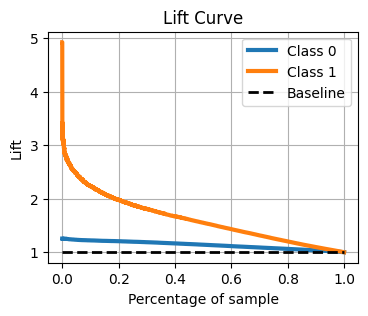

In [43]:
plot_lift_curve(pred_test_df['target'], 
                pd.concat([1-pred_test_df['predict_prob'], pred_test_df['predict_prob']], axis=1), 
                title='Lift Curve', ax=None, figsize=(4,3), 
                title_fontsize='large', text_fontsize='medium')
plt.gca().legend(loc='upper right')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_lift_curve.png'),bbox_inches='tight')

## Feature Importance 

##### XGBoost gain

In [44]:
feat_impgain = pd.DataFrame(xgb_model.get_booster().get_score(importance_type='gain'),
                                     index=['importance']).T \
    .sort_values('importance', ascending=False)

In [45]:
feat_impgain.to_csv(Path(setup.temp_path).joinpath('03_REPORT_importance_gain.csv'), index=True)

In [46]:
feat_impgain.head()

,importance
urban_flag,568.784119
menc_NAICS,199.244446
LowDoc,137.078583
DisbursementGross,80.067795
new_business,34.772827


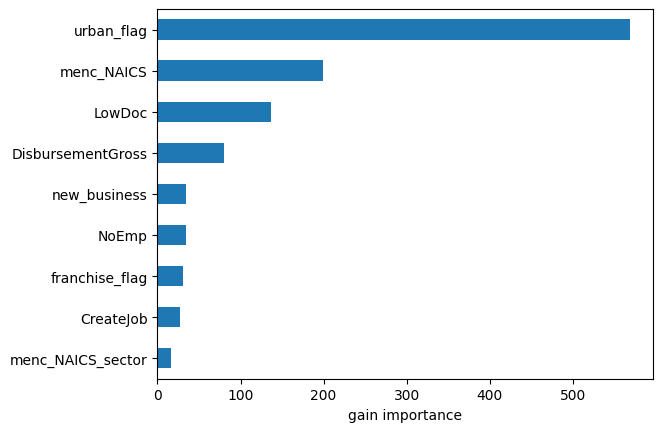

In [47]:
feat_impgain.plot(kind='barh', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('gain importance')
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_importance_gain.png'))

##### Permutation Importance

In [48]:
perm_importance = permutation_importance(xgb_model, train_df[predictor_features], train_df['target'])

In [49]:
perm_importance_df = pd.DataFrame({'features':predictor_features,
                                   'importance': perm_importance['importances_mean']}) 
perm_importance_df['abs_importance'] = np.abs(perm_importance_df['importance'])
perm_importance_df = perm_importance_df.sort_values('abs_importance', ascending=False)

In [50]:
perm_importance_df.head(5)

,features,importance,abs_importance
7,menc_NAICS,0.004252,0.004252
3,DisbursementGross,0.003833,0.003833
1,CreateJob,0.002493,0.002493
5,urban_flag,0.001053,0.001053
2,LowDoc,0.000766,0.000766


In [51]:
perm_importance_df \
    .to_csv(Path(setup.temp_path).joinpath('03_DATA_importance_perturb.csv'),
            index=False)

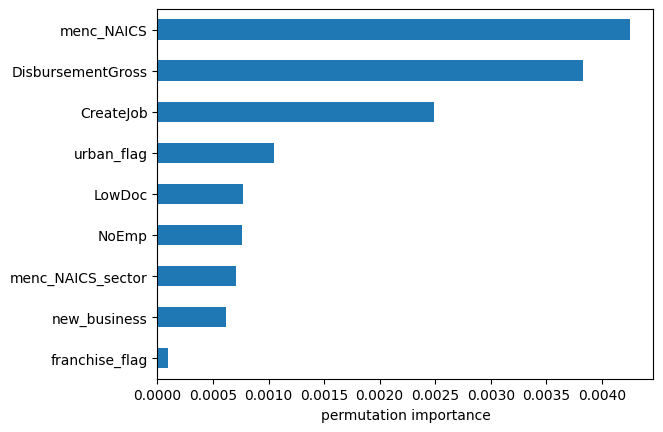

In [52]:
perm_importance_df.head(10).plot(kind='barh', x='features', y='importance', legend=None)
plt.gca().invert_yaxis()
plt.xlabel('permutation importance')
plt.ylabel(None)
plt.gcf().savefig(Path(setup.temp_path).joinpath('03_PLOT_importance_perturb.png'))

## ALE Plot for Mean Encoded NAICS
Get an idea of the independent effect of NAICS (mean encoded)

In [53]:
ale_info = ale(X=train_df[predictor_features],
               model=xgb_model, feature=['menc_NAICS'],
                       plot=False, grid_size = 50)

PyALE._ALE_generic:INFO: Continuous feature detected.


In [54]:
plt.close()

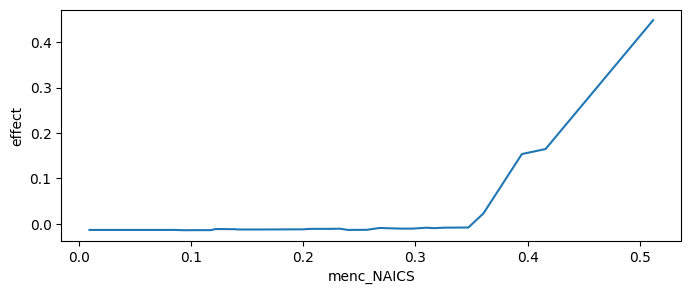

In [55]:
fig, ax = plt.subplots(figsize = (8, 3))
ale_info[['eff']].plot(legend=None, ax=ax)
ax.set_ylabel('effect')
fig.savefig(Path(setup.temp_path).joinpath('03_PLOT_ale_naics_meanenc.png'),
               bbox_inches='tight')